In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowerdatasets/flowers/val/orchid/5479838376_b9ef4b2dd4_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/15317253397_c17cf35524_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/2068689248_2f31a3160b_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/15368996319_9f8354726f_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/8505987237_cf07748498_c.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/6467770439_cf417e8003_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/2452354536_2e0380c81e_c.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/6803947634_f0ed5fec65_k.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/6921280358_c7a94654e2_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/57715059_fc26450350_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/12241437214_05d3b7a7eb_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/2187054004_ca79f859e6_o.jpg
/kaggle/input/flowerdatasets/flowers/val/orchid/16806723606_297fa28edb_k.jpg
/kaggle/in

✅ Libraries imported.
Classes: ['daisy', 'dandelion', 'lily', 'orchid', 'rose', 'sunflower', 'tulip']

[Collect] daisy: 250 images
[Collect] dandelion: 250 images
[Collect] lily: 250 images
[Collect] orchid: 250 images
[Collect] rose: 250 images
[Collect] sunflower: 250 images
[Collect] tulip: 250 images
All descriptors shape: (598336, 128)

Training MiniBatchKMeans with K=700 ...
Init 1/10 with method k-means++
Inertia for init 1/10: 1590.5478515625
Init 2/10 with method k-means++
Inertia for init 2/10: 1591.84912109375
Init 3/10 with method k-means++
Inertia for init 3/10: 1585.302978515625
Init 4/10 with method k-means++
Inertia for init 4/10: 1595.12744140625
Init 5/10 with method k-means++
Inertia for init 5/10: 1600.3006591796875
Init 6/10 with method k-means++
Inertia for init 6/10: 1600.809814453125
Init 7/10 with method k-means++
Inertia for init 7/10: 1592.4329833984375
Init 8/10 with method k-means++
Inertia for init 8/10: 1592.3829345703125
Init 9/10 with method k-means++
I

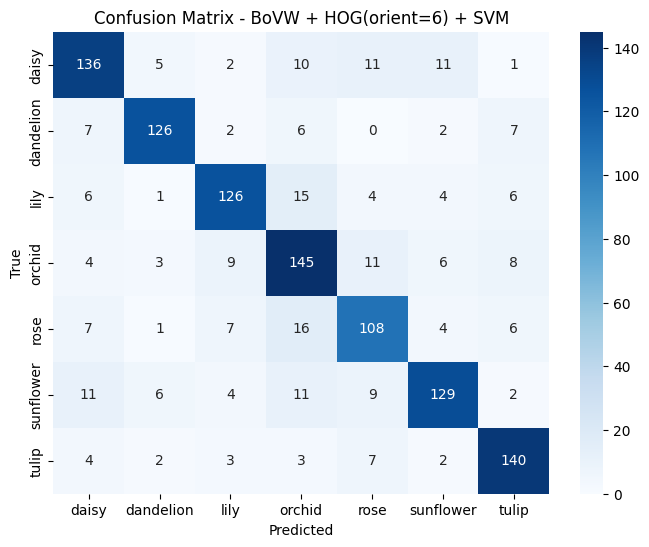


Finding correct and incorrect predictions...
Total correct: 910
Total incorrect: 246

3 ẢNH DỰ ĐOÁN ĐÚNG


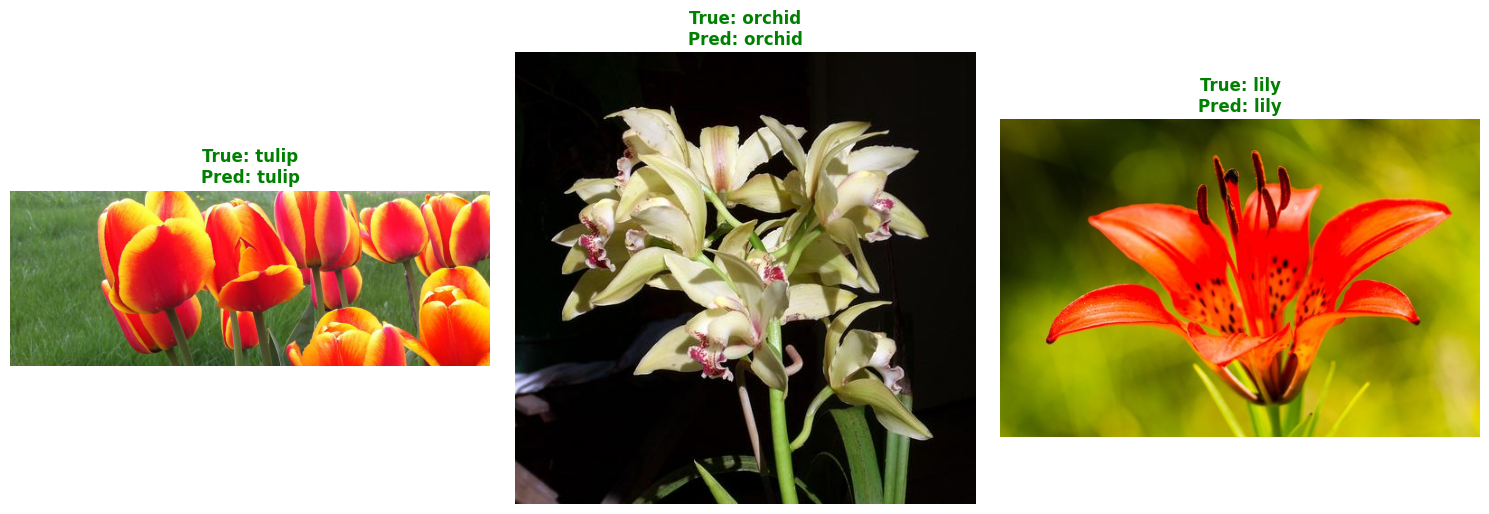


3 ẢNH DỰ ĐOÁN SAI


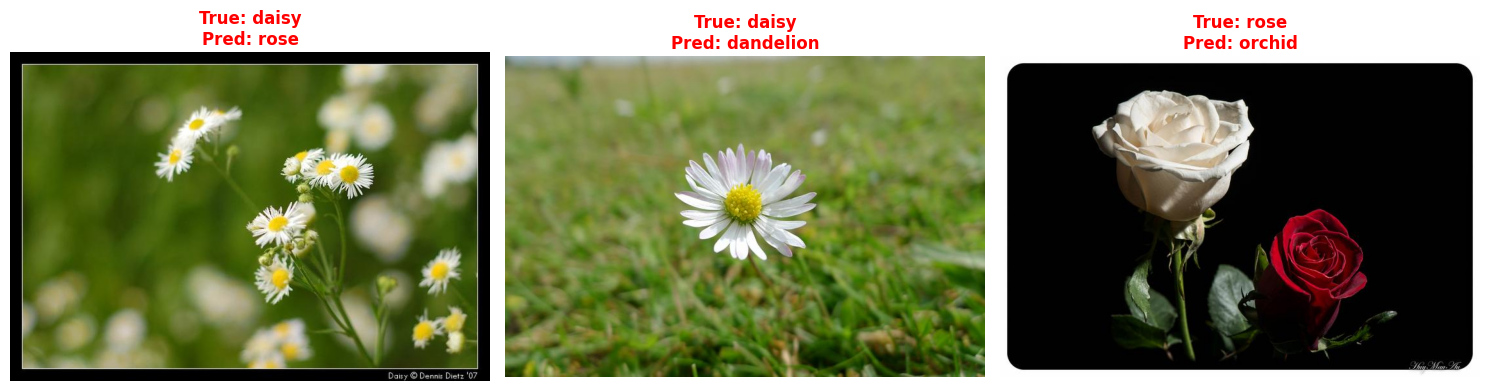


✅ Đã lưu xong file: bovw_hog_svm.pkl
Best HOG orientations: 6


In [2]:
# ============================================
# BoVW (RootSIFT) + HOG + SVM Flower Classification
# ============================================

# Import & Setup
import os
from pathlib import Path

import cv2
import numpy as np

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("✅ Libraries imported.")

# ============================================
# Paths
# ============================================
BASE_DIR = "/kaggle/input/flowerdatasets/flowers"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

base_dir = Path(BASE_DIR)
train_dir = Path(TRAIN_DIR)
val_dir   = Path(VAL_DIR)
test_dir  = Path(TEST_DIR)

class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print("Classes:", class_names)

# ============================================
# RootSIFT Extractor
# ============================================

sift = cv2.SIFT_create()

def extract_rootsift_descriptors(img_gray, max_kp=500):
    """
    Trích xuất RootSIFT descriptors từ ảnh grayscale.
    img_gray: ảnh grayscale (ndarray)
    """
    keypoints, desc = sift.detectAndCompute(img_gray, None)
    if desc is None:
        return None

    if desc.shape[0] > max_kp:
        desc = desc[:max_kp]
        
    # ======= RootSIFT =======
    desc = desc.astype("float32")
    # 1) L1 normalize từng descriptor
    desc /= (desc.sum(axis=1, keepdims=True) + 1e-7)
    # 2) Căn bậc hai từng phần tử
    desc = np.sqrt(desc)

    return desc


# ============================================
# HOG Feature Extractor
# ============================================

def extract_hog(img, orientations=9, resize_shape=(128, 128)):
    """
    Trích HOG feature cho shape/texture.
    """
    img_resized = cv2.resize(img, resize_shape)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    hog_feat = hog(
        gray,
        orientations=orientations, 
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True,
        channel_axis=None 
    )
    return hog_feat


# ============================================
# Thu thập SIFT descriptors từ train
# ============================================

def collect_descriptors_from_train(train_folder, max_images_per_class=250):
    """
    Thu thập tất cả SIFT descriptors từ tập train để train codebook.
    """
    all_desc = []
    train_folder = Path(train_folder)

    for cls in class_names:
        cls_dir = train_folder / cls
        img_files = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_files.extend(cls_dir.glob(ext))

        img_files = img_files[:max_images_per_class]
        print(f"[Collect] {cls}: {len(img_files)} images")
        
        for img_path in img_files:
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            img_gray = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2GRAY)
            desc = extract_rootsift_descriptors(img_gray)
            if desc is not None:
                all_desc.append(desc)

    if not all_desc:
        return None

    all_desc = np.vstack(all_desc)
    return all_desc


print("\n" + "="*50)
print("Collecting SIFT descriptors from training set...")
print("="*50)

all_desc = collect_descriptors_from_train(train_dir, max_images_per_class=250)
print("All descriptors shape:", all_desc.shape)


# ============================================
# Train Codebook (K-means)
# ============================================

K = 700  # Số "visual words"

print("\n" + "="*50)
print(f"Training MiniBatchKMeans with K={K} ...")
print("="*50)

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=2000,
    n_init=10,
    random_state=42,
    verbose=1
)
kmeans.fit(all_desc)
print("✅ Codebook trained.")


# ============================================
# Trích BoVW + HOG cho 1 ảnh
# ============================================

def image_to_bovw_hog(img_path, hog_orientations=9):
    """
    Trả về feature vector = [BoVW_RootSIFT, HOG]
    """
    img = cv2.imread(str(img_path))
    if img is None:
        # fallback vector zeros
        # HOG với orientation=9: 3969 dims
        return np.zeros(K + 3969, dtype=np.float32)

    img_resized = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # --- BoVW từ RootSIFT ---
    desc = extract_rootsift_descriptors(gray)
    if desc is None:
        bovw_hist = np.zeros(K, dtype=np.float32)
    else:
        words = kmeans.predict(desc)
        bovw_hist, _ = np.histogram(words, bins=np.arange(K+1))
        bovw_hist = bovw_hist.astype("float32")
        # Hellinger normalization
        bovw_hist /= (bovw_hist.sum() + 1e-7)
        bovw_hist = np.sqrt(bovw_hist)

    # --- HOG feature ---
    hog_feat = extract_hog(img_resized, orientations=hog_orientations)

    # --- Gộp ---
    feat = np.hstack([bovw_hist, hog_feat])
    return feat


# ============================================
# Load Dataset với BoVW + HOG features
# ============================================

def load_bovw_hog_dataset(folder, hog_orientations=9):
    """
    Load dataset với BoVW + HOG features.
    """
    X, y = [], []
    folder = Path(folder)

    for label, cls in enumerate(class_names):
        cls_dir = folder / cls
        img_files = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_files.extend(cls_dir.glob(ext))

        print(f"[Load] {folder.name} - {cls}: {len(img_files)} images")

        for img_path in img_files:
            feat = image_to_bovw_hog(img_path, hog_orientations=hog_orientations)
            X.append(feat)
            y.append(label)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)


# ============================================
# Grid Search cho HOG orientations
# ============================================

orientation_list = [6, 7, 8, 9]
best_orientation = None
best_val_acc = 0.0
best_config = None

print("\n" + "="*50)
print("GRID SEARCH HOG ORIENTATIONS")
print("="*50)

for orient in orientation_list:
    print(f"\n{'='*50}")
    print(f"Testing with orientations={orient}")
    print('='*50)
    
    # Load dataset với orientation hiện tại
    X_train, y_train = load_bovw_hog_dataset(train_dir, hog_orientations=orient)
    X_val,   y_val   = load_bovw_hog_dataset(val_dir, hog_orientations=orient)
    
    print("\nDataset shapes:")
    print("Train:", X_train.shape, y_train.shape)
    print("Val  :", X_val.shape,   y_val.shape)
    
    # Chuẩn hóa + PCA
    scaler_temp = StandardScaler()
    X_train_scaled = scaler_temp.fit_transform(X_train)
    X_val_scaled   = scaler_temp.transform(X_val)
    
    pca_temp = PCA(n_components=192, random_state=42)
    X_train_pca = pca_temp.fit_transform(X_train_scaled)
    X_val_pca   = pca_temp.transform(X_val_scaled)
    
    # Train SVM
    clf = SVC(C=10, gamma="scale", kernel="rbf", random_state=42)
    clf.fit(X_train_pca, y_train)
    
    # Đánh giá trên validation
    val_pred = clf.predict(X_val_pca)
    val_acc = accuracy_score(y_val, val_pred)
    
    print(f"\nValidation accuracy: {val_acc:.4f}")
    
    # Cập nhật best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_orientation = orient
        best_config = {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val
        }

print("\n" + "="*50)
print("BEST HOG ORIENTATION")
print("="*50)
print(f"Best orientation: {best_orientation}")
print(f"Best val accuracy: {best_val_acc:.4f}")


# ============================================
# Load Test Set với best orientation
# ============================================

print("\n" + "="*50)
print(f"Loading test set with orientations={best_orientation}...")
print("="*50)

X_test, y_test = load_bovw_hog_dataset(test_dir, hog_orientations=best_orientation)
print("Test :", X_test.shape, y_test.shape)


# ============================================
# Train Final Model với best orientation
# ============================================

print("\n" + "="*50)
print("Training final model on Train+Val...")
print("="*50)

# Lấy dữ liệu train/val từ best config
X_train = best_config['X_train']
y_train = best_config['y_train']
X_val = best_config['X_val']
y_val = best_config['y_val']

# Gộp train và val
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

# FIT LẠI scaler và PCA từ đầu
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)

pca = PCA(n_components=192, random_state=42)
X_train_full_pca = pca.fit_transform(X_train_full_scaled)

# Transform test
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Train final model
svm_final = SVC(C=10, gamma="scale", kernel="rbf", random_state=42, probability=True)
svm_final.fit(X_train_full_pca, y_train_full)

print("✅ Final model trained.")


# ============================================
# Đánh giá trên Test Set
# ============================================

test_pred = svm_final.predict(X_test_pca)
test_acc = accuracy_score(y_test, test_pred)

print("\n" + "="*50)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*50)
print("Test accuracy:", test_acc)
print("\nClassification report:")
print(classification_report(y_test, test_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - BoVW + HOG(orient={best_orientation}) + SVM")
plt.show()


# ============================================
# Hàm dự đoán một ảnh bất kỳ
# ============================================

def predict_image(img_path: str):
    """
    Dự đoán loài hoa từ đường dẫn ảnh.
    """
    feats = image_to_bovw_hog(img_path, hog_orientations=best_orientation)
    feats = feats.reshape(1, -1)
    feats_scaled = scaler.transform(feats)
    feats_pca = pca.transform(feats_scaled)
    pred_idx = svm_final.predict(feats_pca)[0]
    return class_names[pred_idx]


# Ví dụ test với một ảnh
sample_img_path = '/kaggle/input/test-demo/image42-1660292012-557-width2048height1560.jpg'
if os.path.exists(sample_img_path):
    print("\n" + "="*50)
    print("Test prediction on sample image")
    print("="*50)
    print("Sample image:", sample_img_path)
    print("Predicted:", predict_image(str(sample_img_path)))


# ============================================
# Hiển thị ảnh dự đoán đúng và sai
# ============================================

print("\n" + "="*50)
print("Finding correct and incorrect predictions...")
print("="*50)

# Lấy danh sách tất cả ảnh test
test_images = []
for label, cls in enumerate(class_names):
    cls_dir = test_dir / cls
    img_files = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        img_files.extend(cls_dir.glob(ext))
    
    for img_path in img_files:
        test_images.append((img_path, label))

# Dự đoán và phân loại
correct_predictions = []
incorrect_predictions = []

for img_path, true_label in test_images:
    feats = image_to_bovw_hog(img_path, hog_orientations=best_orientation)
    feats = feats.reshape(1, -1)
    feats_scaled = scaler.transform(feats)
    feats_pca = pca.transform(feats_scaled)
    pred_label = svm_final.predict(feats_pca)[0]
    
    if pred_label == true_label:
        correct_predictions.append((img_path, true_label, pred_label))
    else:
        incorrect_predictions.append((img_path, true_label, pred_label))

print(f"Total correct: {len(correct_predictions)}")
print(f"Total incorrect: {len(incorrect_predictions)}")

# Hiển thị 3 ảnh dự đoán đúng
if len(correct_predictions) >= 3:
    print("\n" + "="*50)
    print("3 ẢNH DỰ ĐOÁN ĐÚNG")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    np.random.seed(42)
    sample_correct = np.random.choice(len(correct_predictions), 3, replace=False)
    
    for idx, sample_idx in enumerate(sample_correct):
        img_path, true_label, pred_label = correct_predictions[sample_idx]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                           color='green', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Hiển thị 3 ảnh dự đoán sai
if len(incorrect_predictions) >= 3:
    print("\n" + "="*50)
    print("3 ẢNH DỰ ĐOÁN SAI")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    np.random.seed(42)
    sample_incorrect = np.random.choice(len(incorrect_predictions), 3, replace=False)
    
    for idx, sample_idx in enumerate(sample_incorrect):
        img_path, true_label, pred_label = incorrect_predictions[sample_idx]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                           color='red', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


# ============================================
# Lưu Model
# ============================================

model_data = {
    "kmeans": kmeans,                    # Để tạo BoVW từ SIFT
    "scaler": scaler,                    # Để chuẩn hóa dữ liệu
    "pca": pca,                          # Để giảm chiều dữ liệu
    "model": svm_final,                  # Model SVM cuối cùng
    "class_names": class_names,          # Danh sách tên các loài hoa
    "K_value": K,                        # Số lượng cụm K (700)
    "hog_orientations": best_orientation # Best HOG orientation
}

filename = "bovw_hog_svm.pkl"
with open(filename, "wb") as f:
    pickle.dump(model_data, f)

print("\n" + "="*50)
print(f"✅ Đã lưu xong file: {filename}")
print(f"Best HOG orientations: {best_orientation}")
print("="*50)